In [1]:
import os
os.chdir("..")
import aerodynamics
os.chdir("Tutorials")

stru_history = "data/bscw_amplitudex2/StructHistoryModal.dat"
aero_history = "data/bscw_amplitudex2/surface_flow.csv"

database = aerodynamics.database(stru_history,aero_history)
model = aerodynamics.physicalModel("data/Modes/Normals.csv","data/Modes/Mode.csv")




Creating the database for the reduced order model.
Importing the data from the files.
Opened structural history file data/bscw_amplitudex2/StructHistoryModal.dat.
Completed reading
Starting the reading of surface_flow.csv files.
Opened time iter 1099 last time iter is 1099
Completed reading
Done
Creating the physical model.
Importing the data from the files.
Obtaining the normals to the different panels.
Completed reading
Obtaining the mode shapes
Starting with the undeformed condition
Obtain now the deformation due to modes
Opened file 1 of 2
Opened file 2 of 2
Completed reading
Done


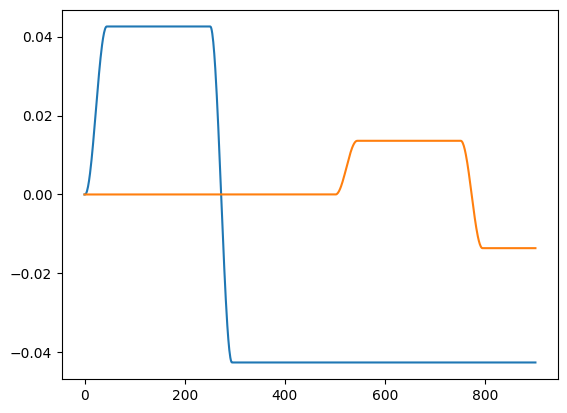

Please select steady state for mode 0:
450
Please select steady state for mode 1:
850


In [22]:
stabilisation = 2  # Brunton stabilisation, please look at the configuration template for more details
database.thresholding = 50
rom = aerodynamics.ROM([database], model, stabilisation)

In [23]:
os.chdir("..")
import structure
os.chdir("Tutorials")
solverConfiguration = {"N_MODES": rom.nmodes, "DELTA_T": rom.deltaT, "MODAL_DAMP": 0.0,
                       "PUNCH_FILE": "data/modal.pch", "INITIAL_MODES": rom.databases[0].Uinit,
                       "INITIAL_VEL": rom.databases[0].Udotinit, "OUTPUTS": "outUntitled.csv"}
solver = structure.solver(solverConfiguration)
solver.writeHeader()
solver.writeSolution()



Configuring the structural solver for FSI simulation
The structural model is undamped
Creating the structural model
Opened punch file data/modal.pch.
Modal stiffness and mass matrices are diagonal
Using 2 degrees of freedom
Setting the integration parameters
Setting initial conditions.
Time iter	q1	qdot1	qddot1	q2	qdot2	qddot2	


In [ ]:
import numpy as np
aeroState = np.empty((database.X.shape[0], 0))

aeroState = np.append(aeroState, rom.Z - rom.Xcenter, axis=1)
from sys import stdout
for i in range(1, 3762):
    stdout.write("\rTime iteration " + str(i) + " of " + str(3761))
    stdout.flush()
    aeroState = np.append(aeroState, rom.predict(solver.q, solver.qdot, solver.qddot) - rom.Xcenter, axis=1)
    solver.applyload(np.array(rom.getModalforces()))
    solver.run()
    solver.updateSolution()
    solver.writeSolution()
    rom.update()
print("\nCompleted time integration")

Time iteration 3626 of 37611	0.0002	0.1695	-24.3354		

In [ ]:
# We now plot the first two modes to verify that indeed we see a slightly unstable behaviour. We also compare with the
# results from the full simulation
mode0 = []
mode1 = []
with open("outUntitled.csv") as file:
    headerline = file.readline()
    line = file.readline()
    while True:
        if not line:
            break
        line.strip("\r\n")
        line = line.split()
        mode0.append(float(line[1]))
        mode1.append(float(line[4]))
        line = file.readline()
        
mode0_ref = []
mode1_ref = []
with open("data/inputsTutorial4.dat") as file:
    headerline = file.readline()
    line = file.readline()
    while True:
        if not line:
            break
        line.strip("\r\n")
        line = line.split()
        mode0_ref.append(float(line[3]))
        mode1_ref.append(float(line[6]))
        line = file.readline()

from matplotlib import pyplot as plt
import numpy as np

plt.plot(0.001*np.linspace(0,len(mode0)-1,len(mode0)), mode0, '-')
plt.plot(0.001*np.linspace(0,len(mode0_ref)-1,len(mode0_ref)), mode0_ref, '--')
plt.plot(0.001*np.linspace(0,len(mode1)-1,len(mode1)), mode1, '-')
plt.plot(0.001*np.linspace(0,len(mode1_ref)-1,len(mode1_ref)), mode1_ref, '--')
# just make the plot pretty
plt.xlabel("Time [s]")
plt.ylabel("Lift [N]")
plt.legend(["Plunge DMD","Plunge Full","Pitch DMD","Pitch Full"])

In [6]:
stru_history2 = "data/numerical_flutter/StructHistoryModal.dat"
aero_history2 = "data/numerical_flutter/surface_flow.csv"

database2 = aerodynamics.database(stru_history2,aero_history2, 30, 5)



Creating the database for the reduced order model.
Importing the data from the files.
Opened structural history file data/numerical_flutter/StructHistoryModal.dat.
Completed reading
Starting the reading of surface_flow.csv files.
Opened time iter 3859 last time iter is 3860
Completed reading
Done


In [49]:
# We also plot the same quantities of the previous tutorial
time1 = 3314#124
time2 = time1 + 65
time3 = time2 + 65


# The data we want must be extracted for a y value of 0.1 m
# We first find the index of time step 700 and 730
index1 = database2.timeIter == time1
index2 = database2.timeIter == time2
index3 = database2.timeIter == time3

# We now extract the vertices close to y = 0.1 m (1 cm close)
undeformedx = np.empty((0))
undeformedy = np.empty((0))
for i in range(len(model.undeformedShape)):
    undeformedx = np.append(undeformedx, model.undeformedShape[i].ux)
    undeformedy = np.append(undeformedy, model.undeformedShape[i].uy)
    


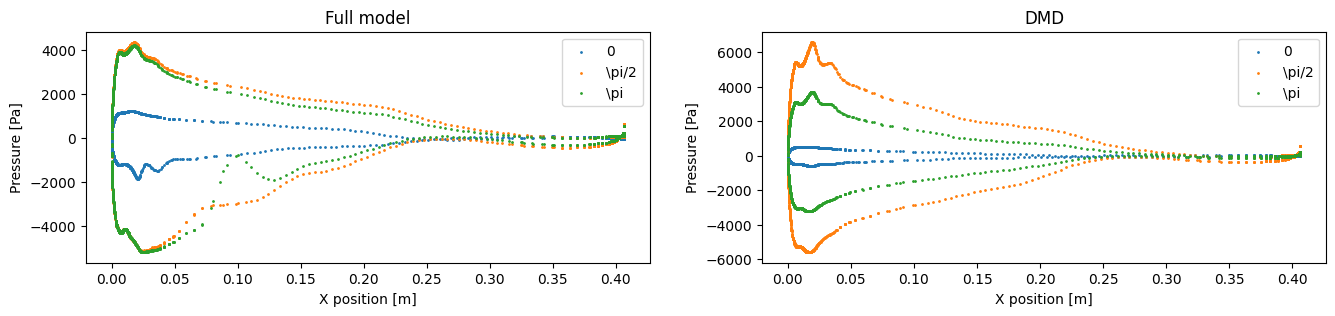

In [50]:
pressure_ref = database2.X - rom.Xcenter
    
positionx = undeformedx[(undeformedy < 0.11) & (undeformedy > 0.09)]
pressure1_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index1]
pressure2_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index2]
pressure3_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index3]
pressure1 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), time1-99]
pressure2 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), time2-99]
pressure3 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), time3-99]
   
plt.figure(figsize=(16,3))

# In blue we will have the distribution before pitching, in orange after

plt.subplot(1,2,1)
plt.scatter(positionx, pressure1_ref, marker='o', s=1)
plt.scatter(positionx, pressure2_ref, marker='o', s=1)
plt.scatter(positionx, pressure3_ref, marker='o', s=1)
plt.xlabel("X position [m]")
plt.ylabel("Pressure [Pa]")
plt.title("Full model")
plt.legend(["0","\pi/2","\pi"])
#plt.ylim(-4000,4000)

plt.subplot(1,2,2)
plt.scatter(positionx, pressure1, marker='o', s=1)
plt.scatter(positionx, pressure2, marker='o', s=1)
plt.scatter(positionx, pressure3, marker='o', s=1)
plt.xlabel("X position [m]")
plt.ylabel("Pressure [Pa]")
plt.title("DMD")
plt.legend(["0","\pi/2","\pi"])
#plt.ylim(-4000,4000)

In [51]:
np.savetxt('pressureTutorial5.csv', aeroState, delimiter=',')
np.savetxt('pressure_refTutorial5.csv', pressure_ref, delimiter=',')